<center>
  <h1 style="background-color:red; color:white; font-size:40px; font-weight:bold; font-family:Times New Roman; border:3px solid black;">Fire Detection Using VGG16</h1>
</center>

<div style="font-family: Cambria; font-weight: bold; letter-spacing: 0px; color: #ffffff; font-size: 120%; text-align: left; padding: 3.0px; background: #003380; border: 10px solid #80ffff;">
    <h1>TABLE OF CONTENTS</h1>
</div>

* [Import Libraries](#0)
* [Read Data](#1)
* [Transfer Learning Model](#2)
* [Model Check](#3)
* [Test Model](#4)
    

<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > Import Libraries<br><div> 

In [1]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Read Data<br><div> 

In [2]:
#Files
path='/kaggle/input/fire-dataset/fire_dataset'
pd.DataFrame(os.listdir(path),columns=['Files'])

Files
0  non_fire_images
1      fire_images

In [3]:
train_data_dir =path
batch_size = 32
target_size = (224, 224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)

Found 999 files belonging to 2 classes.
Using 800 files for training.
Found 999 files belonging to 2 classes.
Using 199 files for validation.


In [4]:
class_names = train.class_names
class_names

['fire_images', 'non_fire_images']

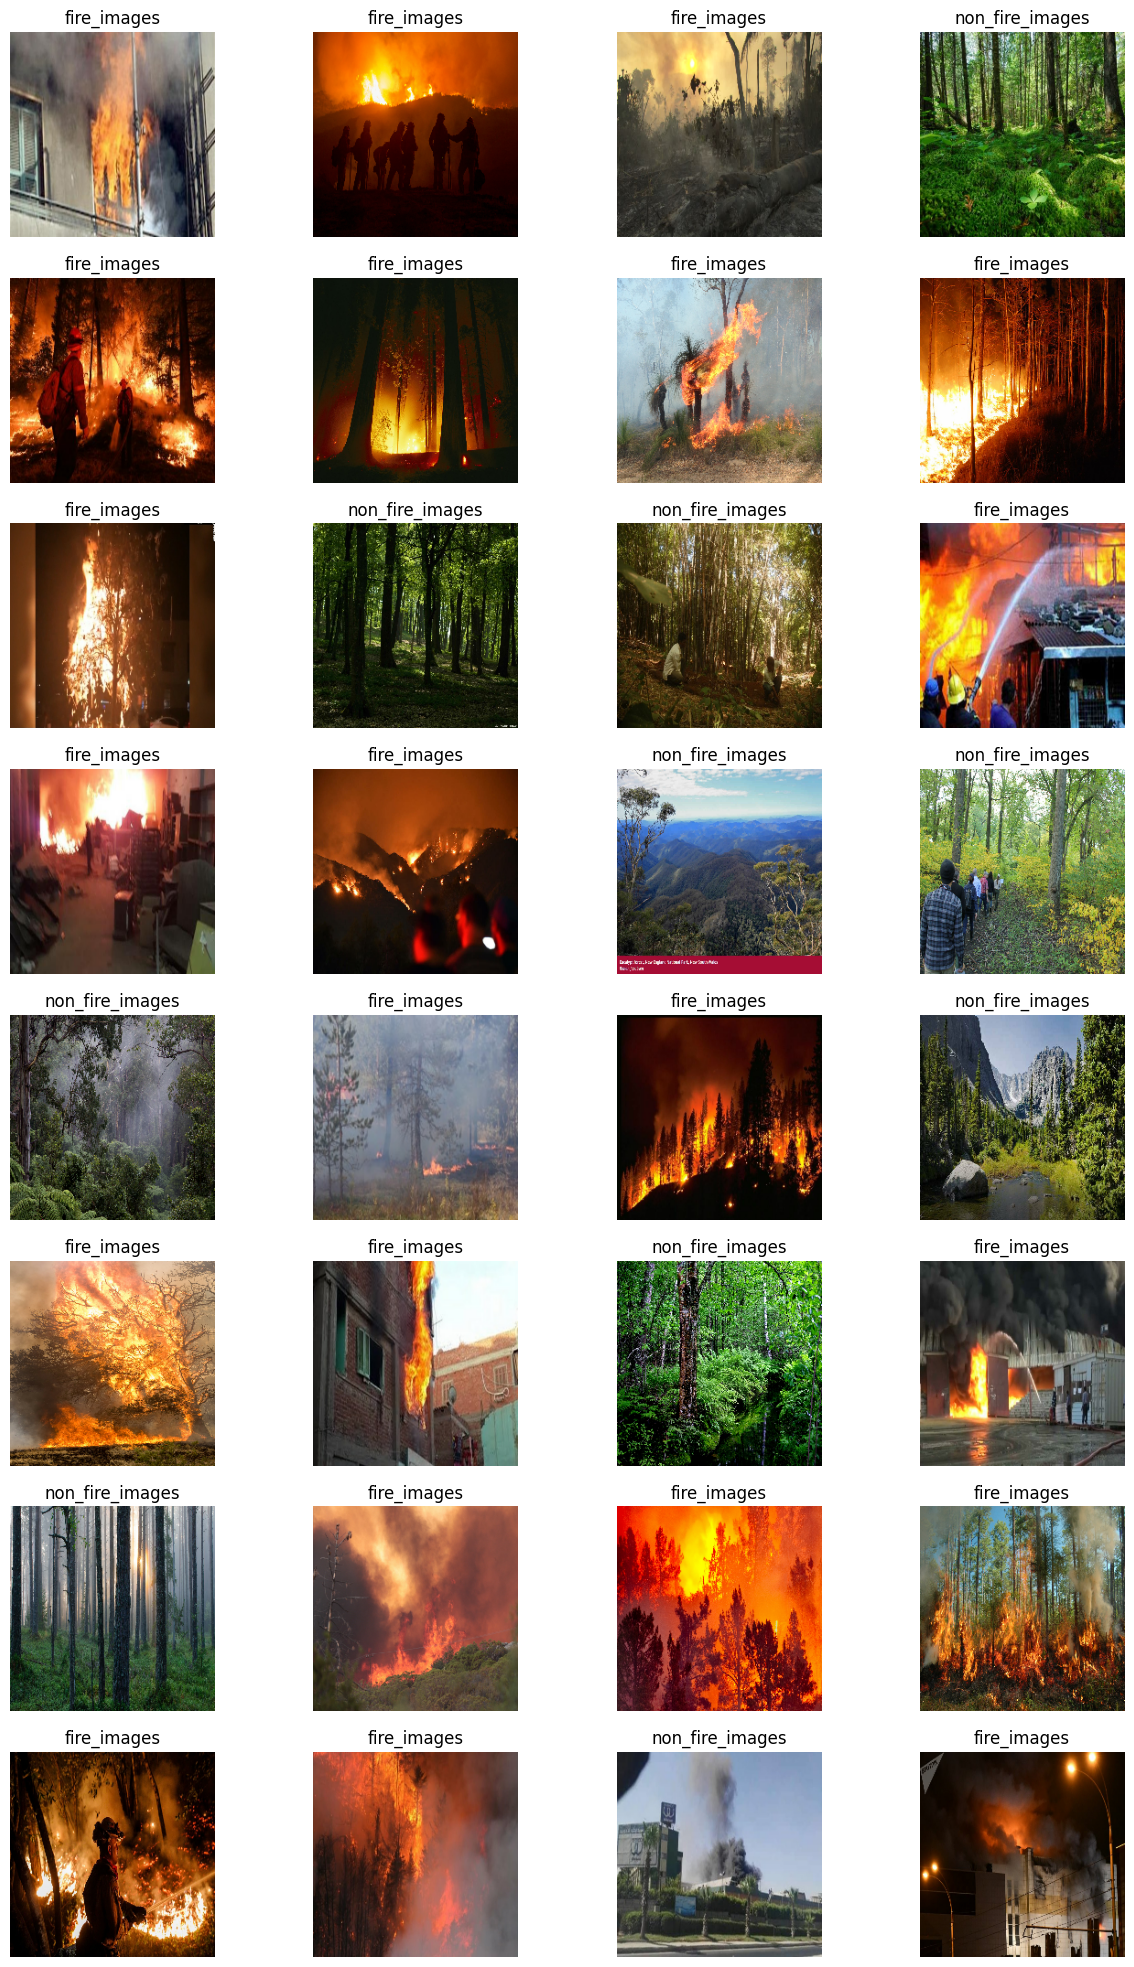

In [5]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Transfer Learning Model<br><div> 

In [6]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
model=keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten()) 
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


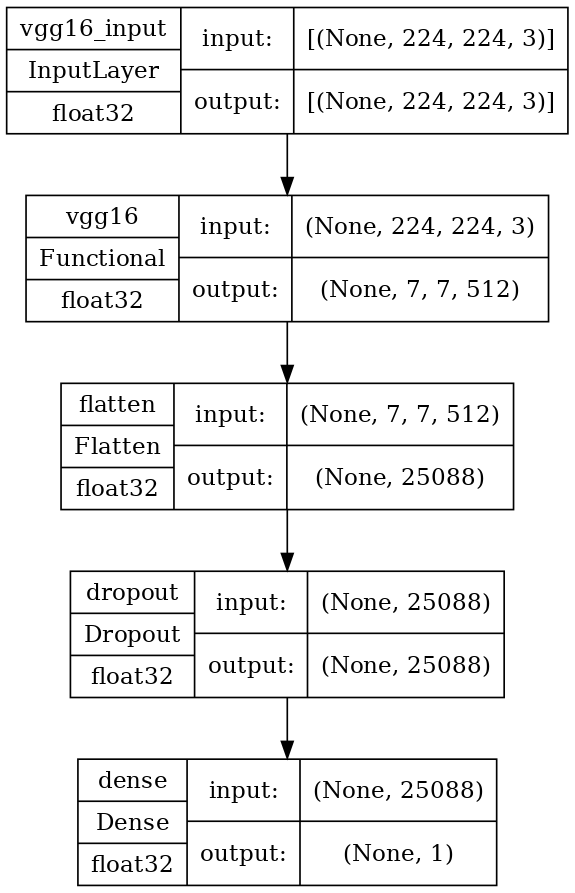

In [7]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [8]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam',loss='binary_crossentropy', metrics=['accuracy'])
hist=model.fit_generator(train,epochs=20,validation_data=validation,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
25/25 [==============================] - 38s 756ms/step - loss: 1.8827 - accuracy: 0.8600 - val_loss: 0.4323 - val_accuracy: 0.9698
Epoch 2/20
25/25 [==============================] - 18s 604ms/step - loss: 0.3737 - accuracy: 0.9613 - val_loss: 0.3267 - val_accuracy: 0.9849
Epoch 3/20
25/25 [==============================] - 18s 572ms/step - loss: 0.1741 - accuracy: 0.9812 - val_loss: 0.3690 - val_accuracy: 0.9849
Epoch 4/20
25/25 [==============================] - 18s 604ms/step - loss: 0.1313 - accuracy: 0.9875 - val_loss: 0.4081 - val_accuracy: 0.9799
Epoch 5/20
25/25 [==============================] - 18s 575ms/step - loss: 0.0388 - accuracy: 0.9925 - val_loss: 0.3272 - val_accuracy: 0.9849
Epoch 6/20
25/25 [==============================] - 17s 568ms/step - loss: 0.0546 - accuracy: 0.9925 - val_loss: 0.3273 - val_accuracy: 0.9849
Epoch 7/20
25/25 [==============================] - 18s 588ms/step - loss: 0.0802 - accuracy: 0.9862 - val_loss: 0.3612 - val_accuracy: 0.9849

In [9]:
score, acc = model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

7/7 [==============================] - 4s 120ms/step - loss: 0.3267 - accuracy: 0.9849
Test Loss = 0.3267461061477661
Test Accuracy = 0.9849246144294739


In [10]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  1.882694   0.86000  0.432256      0.969849
1  0.373676   0.96125  0.326746      0.984925
2  0.174133   0.98125  0.369015      0.984925
3  0.131267   0.98750  0.408072      0.979900
4  0.038761   0.99250  0.327226      0.984925
5  0.054557   0.99250  0.327314      0.984925
6  0.080210   0.98625  0.361241      0.984925

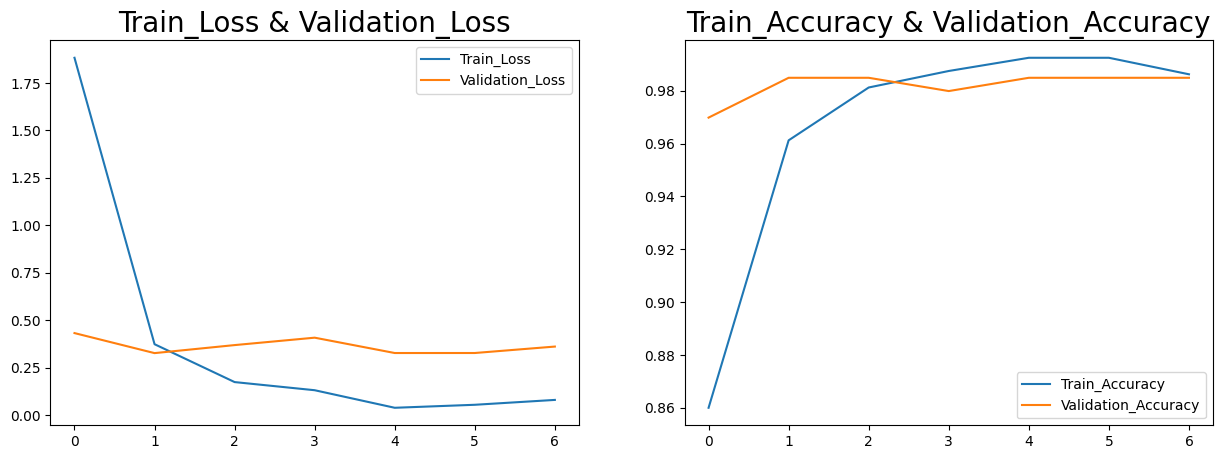

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [12]:
X_val,y_val=[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
y_pred=np.where(predictions>=.5,1,0)
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

7/7 [==============================] - 1s 132ms/step


Actual  Prediction
0         0           0
1         0           0
2         0           0
3         0           0
4         0           0
..      ...         ...
194       0           0
195       0           0
196       0           0
197       0           0
198       0           0

[199 rows x 2 columns]

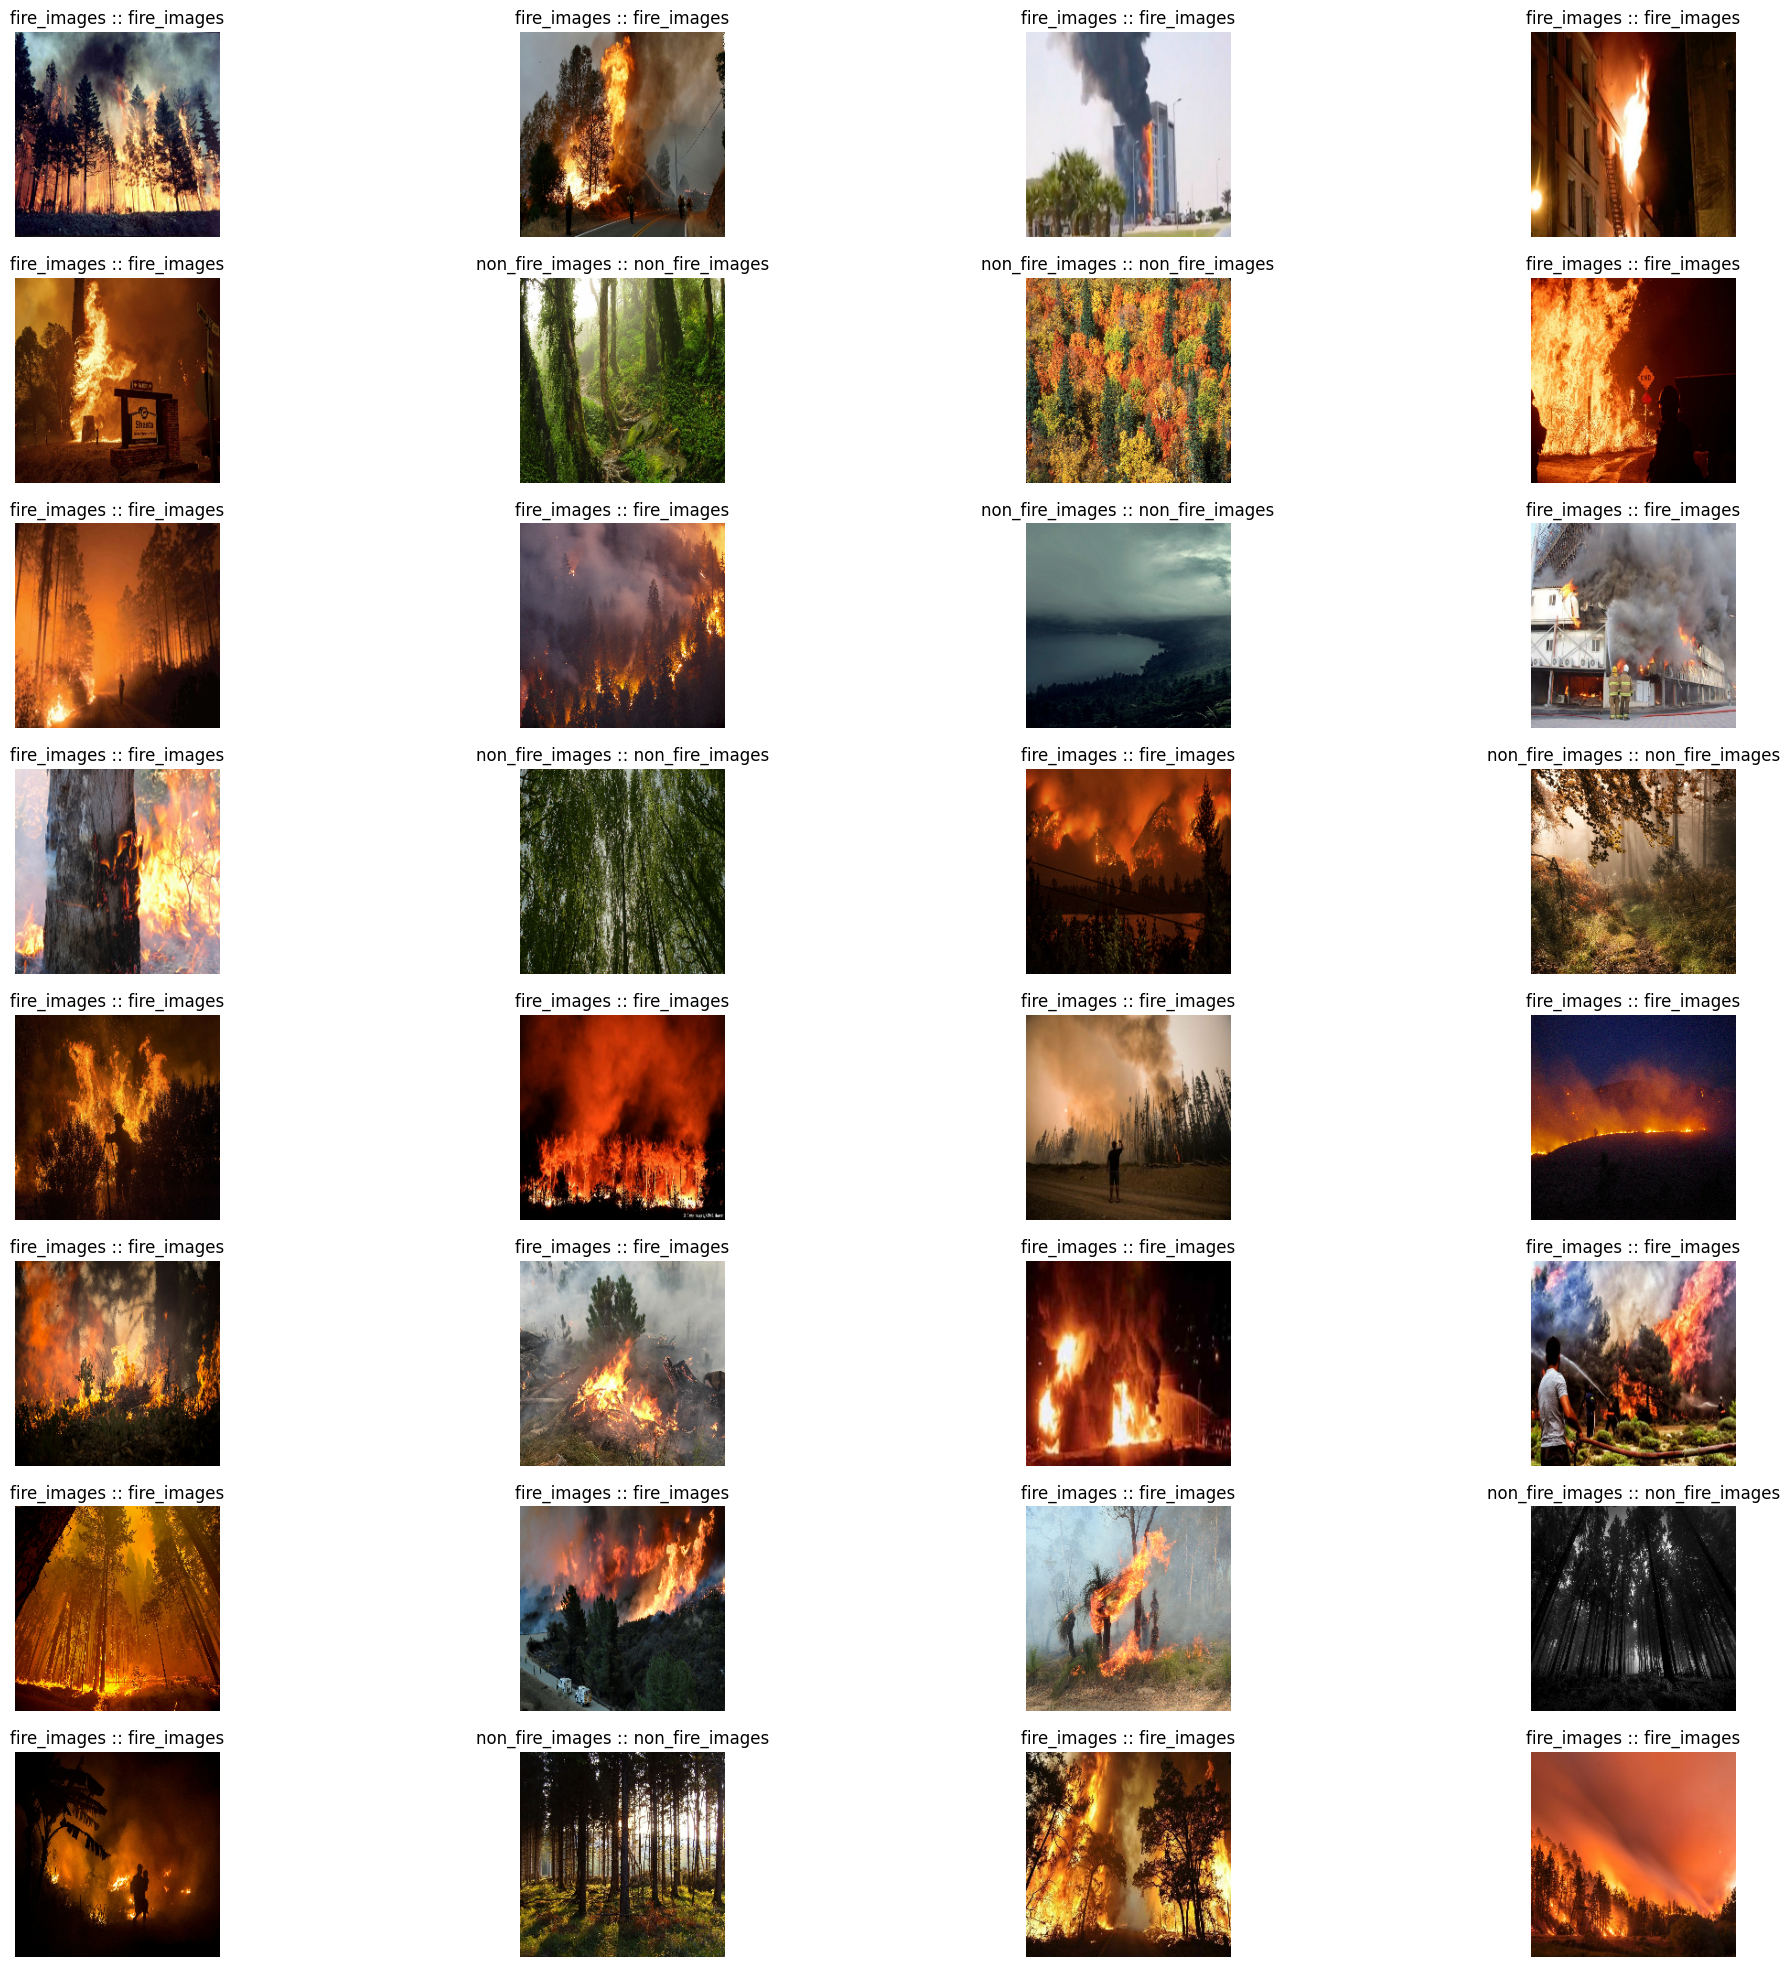

In [13]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i][0]]}')
    plt.axis("off")

<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Model Check<br><div> 

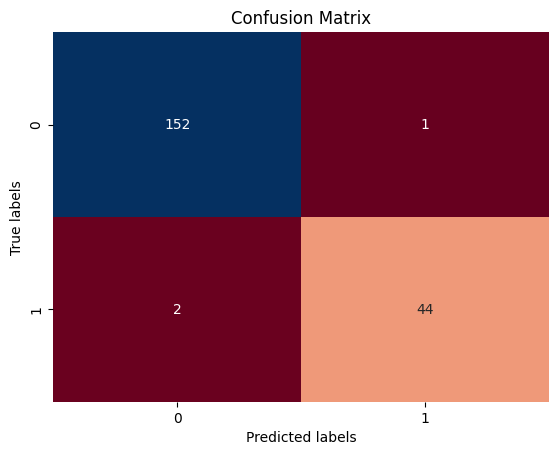

array([[152,   1],
       [  2,  44]])

In [14]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

In [15]:
ClassificationReport = classification_report(y_val,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      0.99      0.99       153
           1       0.98      0.96      0.97        46

    accuracy                           0.98       199
   macro avg       0.98      0.97      0.98       199
weighted avg       0.98      0.98      0.98       199



<a id="0.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" >Test Model<br><div> 

1/1 [==============================] - 0s 20ms/step


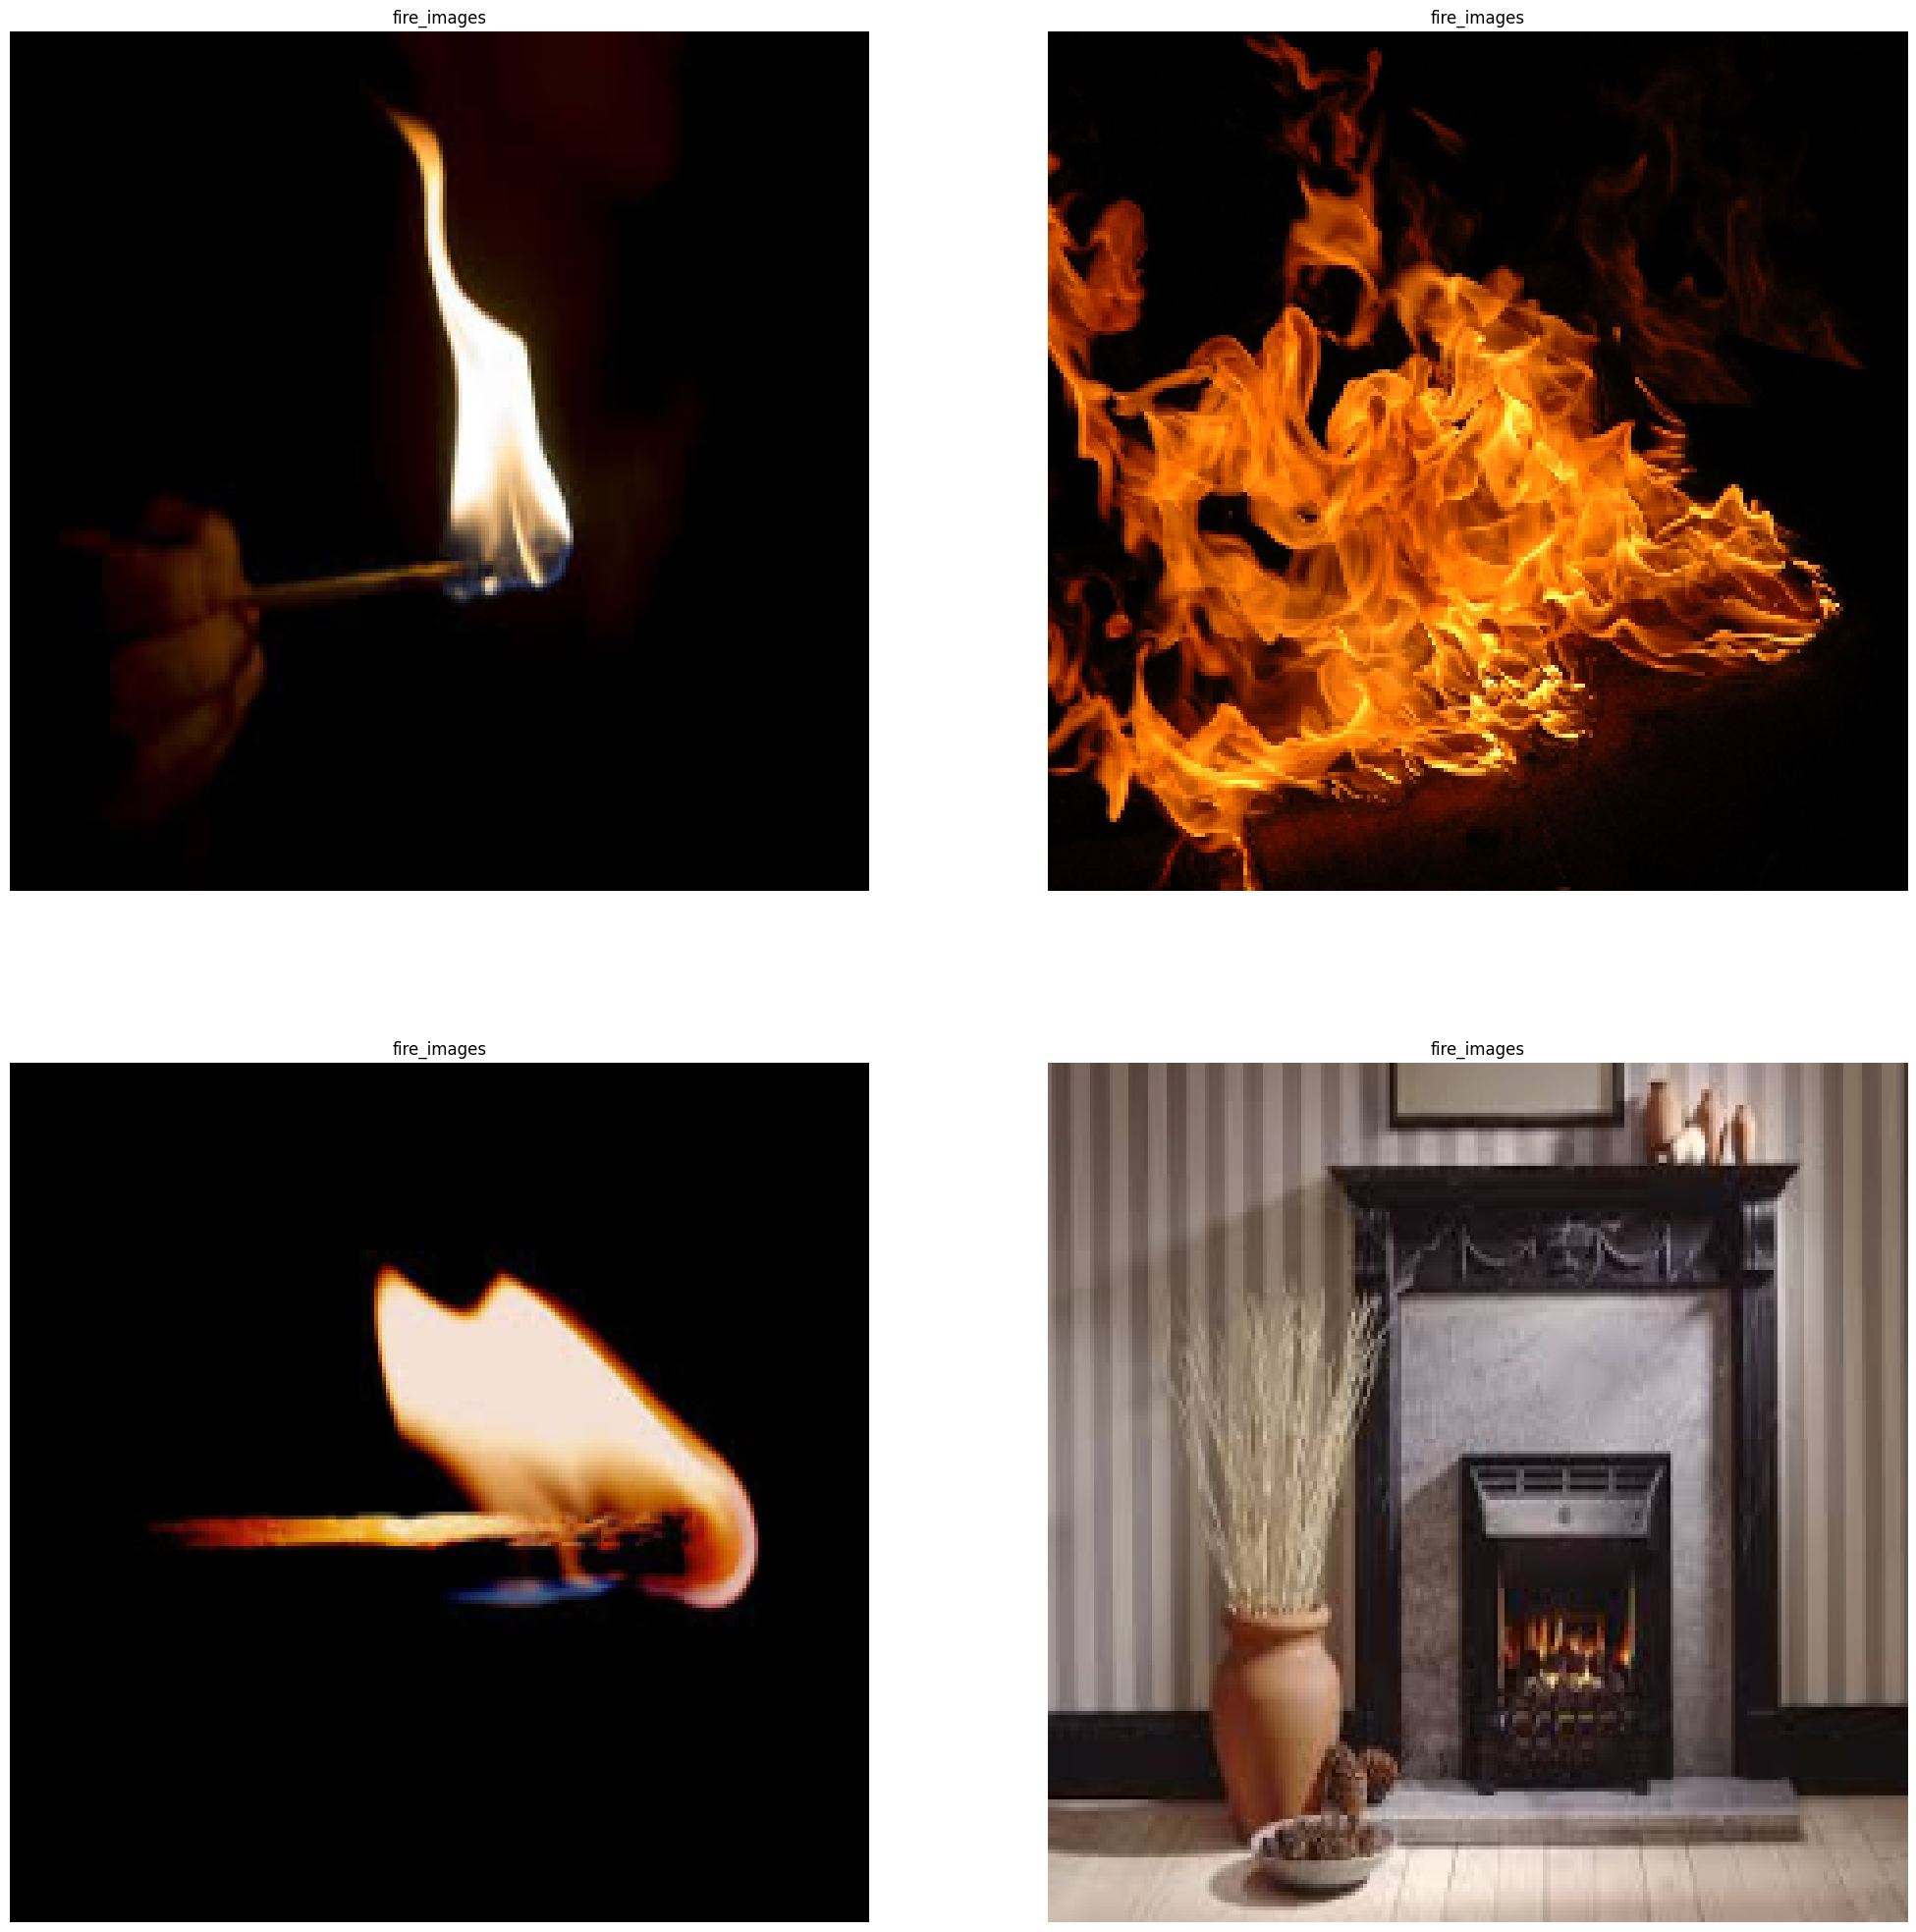

In [16]:
def Test(path):
    save_model = keras.models.load_model('/kaggle/working/my_keras_model.h5')
    images = []
    pred = []
    class_names = ['fire_images', 'non_fire_images']
    for img in os.listdir(path):
        image = cv2.imread(os.path.join(path, img))
        image = cv2.resize(image, (224, 224))
        image =cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        images.append(image)
        image = np.expand_dims(image, axis=0)
        predict = save_model.predict(image)
        pred.append(np.where(predict >= 0.5, 1, 0))
    plt.figure(figsize=(25, 25))
    for i in range(len(pred)):
        plt.subplot(int(np.ceil(len(pred) / 2)), 2, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(f'{class_names[pred[i][0][0]]}')
        plt.axis("off")
    plt.show()

Test('/kaggle/input/test-iamge')

<center>
  <h1 style="background-color:red; color:white; font-size:40px; font-weight:bold; font-family:Times New Roman; border:3px solid black;">Upvotes</h1>
</center>